In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
import covidcast
from datetime import date

In [5]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [6]:
data = pd.read_feather('data/CovidCastStateAdj_2.feather').iloc[:,:-1]

In [7]:
data

,geo_value,time_value,deaths,completely_home_prop,median_home_dwell_time,full_time_work_prop,part_time_work_prop
0,al,2020-01-22,0.000000,0.183999,655.805922,0.086965,0.151171
1,al,2020-01-23,0.000000,0.171479,636.370230,0.103856,0.161668
2,al,2020-01-24,0.000000,0.169182,596.711830,0.104405,0.174012
3,al,2020-01-25,0.000000,0.172661,687.538565,0.083919,0.149298
4,al,2020-01-26,0.000000,0.193669,699.710495,0.087651,0.152943
...,...,...,...,...,...,...,...
9066,wv,2020-07-28,0.672611,0.273833,646.344539,0.039517,0.062896
9067,wv,2020-07-29,1.642459,0.270546,637.137487,0.042846,0.068807
9068,wv,2020-07-30,1.000000,0.266332,606.638365,0.051520,0.079922
9069,wv,2020-07-31,4.000000,0.246038,599.132159,0.041380,0.067567


In [8]:
iv=[5]

In [9]:
Y_raw = np.array(data[data.geo_value == 'ny'].deaths)
A_raw = np.array(data[data.geo_value == 'ny'].iloc[:,iv])

In [10]:
Y_raw.shape, A_raw.shape

((193,), (193, 1))

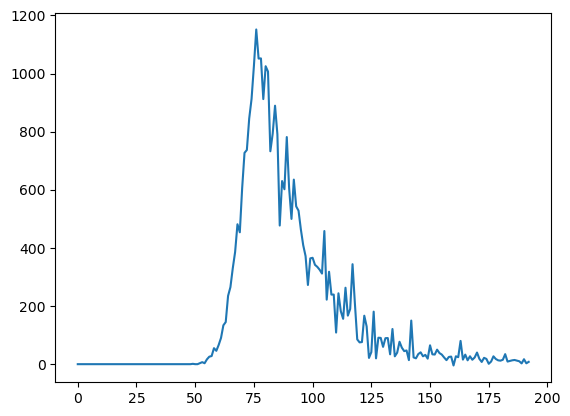

In [11]:
plt.plot(Y_raw)

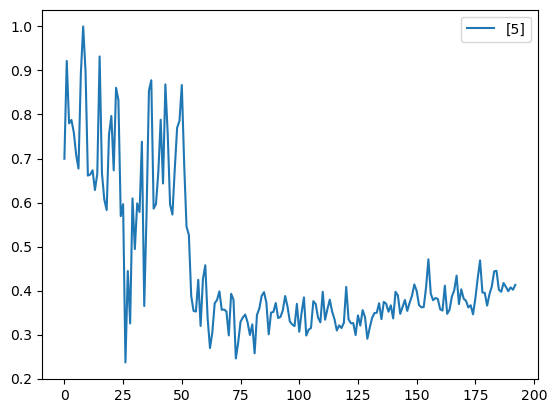

In [12]:
plt.plot(A_raw/np.max(A_raw, 0), label=iv)
plt.legend()

# 2. EDA

In [13]:
POI = np.sum(np.cumsum(Y_raw) < 10)
Y_data = np.maximum(np.round(Y_raw[POI:]), 0).astype(int)

In [14]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

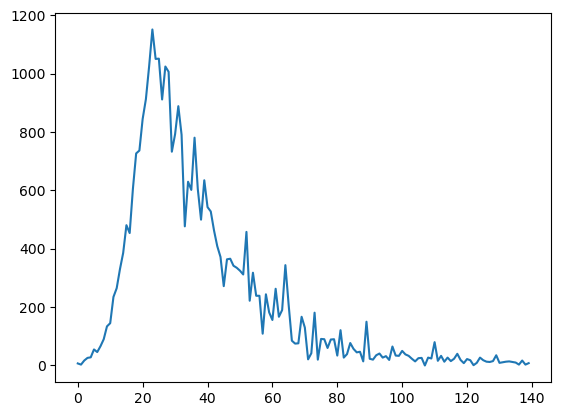

In [15]:
plt.plot(Y_data)

In [16]:
GPi = np.load('data/GPi.npz')

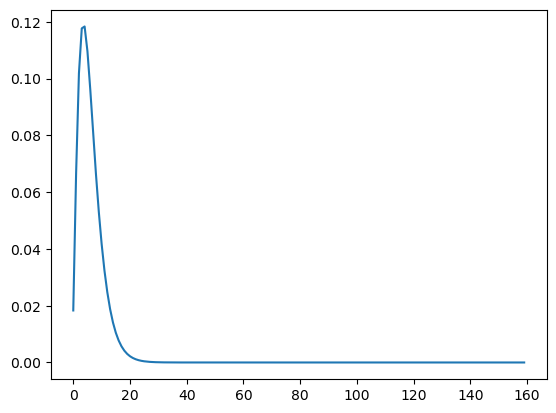

In [17]:
# g
g = np.zeros(T+T0)
g[:GPi['g'].shape[0]] = GPi['g']
plt.plot(g)

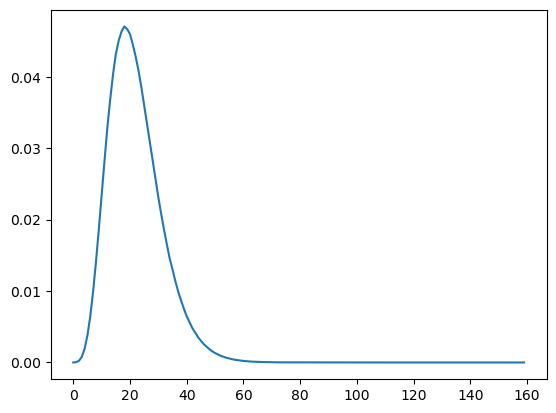

In [18]:
# pi
pi = np.zeros(T+T0)
pi[:GPi['pi'].shape[0]] = GPi['pi']
plt.plot(pi)

In [19]:
# A
d = len(iv)+1
A = np.zeros([T+T0, d])

In [20]:
A[:,0] = np.full(T+T0, 1)
A[:,1:] = A_raw[POI-T0:,:]/np.max(A_raw[:,:], 0)

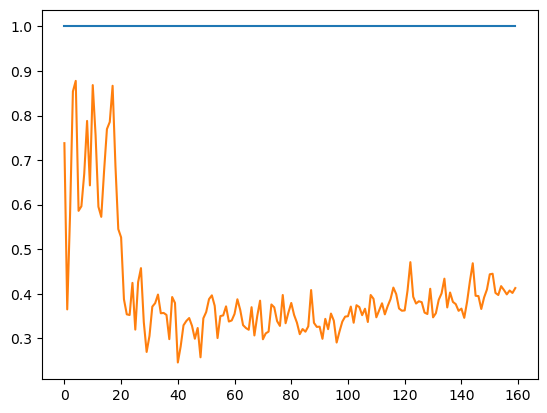

In [21]:
plt.plot(A)

# 3. fit by EM algorithm

In [22]:
def fit(obs, minit_0, sinit_eps, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    mhat_0=minit_0
    shat_eps = sinit_eps
    bhat=binit
    ss=np.inf
    
    # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
    
    if history:
        mhs_0 = np.zeros(n_iter)
        shs_eps = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(- bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
    if verbose:
        print("Before EM, shat_eps: %f"%shat_eps)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # iteration for mu
        mhat_0 = (obs @ Pi_inv_ImG[:,0]) / np.sum((Pi_inv_ImG[:,0])**2)
        # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
        
        # iteration for beta
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        EY = mhat_0 * Pi_inv_ImG[:,0]
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        d1f = - (2/(T+T0)/shat_eps**2) * d1EY @ (obs - EY)
        d2f = (2/(T+T0)/shat_eps**2) * (d1EY @ d1EY.T - d2EY @ (obs-EY))
        
        u, v = la.eig(d2f)
        db = np.real(((v/np.maximum(u,np.max(u)/100)) @ v.T) @ d1f)
        ss = np.min([ss, step_size/np.sqrt(np.sum(db**2))])
        bhat = bhat - ss * db
        
        for t in np.arange(T+T0):
            o = np.exp(- bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
        if history:
            mhs_0[i] = mhat_0
            shs_eps[i] = shat_eps
            bhs[i] = bhat
        
        if verbose:
            print("%d-th iteration finished, shat_eps: %f, lapse: %.3fsec."
                  %(i+1, shat_eps, time.time()-start_iter))
            
    if history:
        return mhs_0, shs_eps, bhs
    else:
        return mhat_0, shat_eps, bhat

In [23]:
mmle_0 = 17.4
smle_eps = 138.5
bmle = np.array([0.207, 1.872])

In [24]:
%%notify
mhs_0, shs_eps, bhs =\
    fit(Y_data, mmle_0, smle_eps, bmle, 
        history=True, verbose=True, n_iter=2000, step_size=0.05)

Before EM, shat_eps: 322682529963548800.000000
1-th iteration finished, shat_eps: 373.607871, lapse: 0.028sec.
2-th iteration finished, shat_eps: 373.607811, lapse: 0.024sec.
3-th iteration finished, shat_eps: 373.607748, lapse: 0.010sec.
4-th iteration finished, shat_eps: 373.607684, lapse: 0.005sec.
5-th iteration finished, shat_eps: 373.607618, lapse: 0.020sec.
6-th iteration finished, shat_eps: 373.607551, lapse: 0.007sec.
7-th iteration finished, shat_eps: 373.607481, lapse: 0.009sec.
8-th iteration finished, shat_eps: 373.607409, lapse: 0.015sec.
9-th iteration finished, shat_eps: 373.607334, lapse: 0.008sec.
10-th iteration finished, shat_eps: 373.607258, lapse: 0.006sec.
11-th iteration finished, shat_eps: 373.607179, lapse: 0.021sec.
12-th iteration finished, shat_eps: 373.607097, lapse: 0.007sec.
13-th iteration finished, shat_eps: 373.607013, lapse: 0.023sec.
14-th iteration finished, shat_eps: 373.606926, lapse: 0.034sec.
15-th iteration finished, shat_eps: 373.606835, laps

128-th iteration finished, shat_eps: 120.038763, lapse: 0.005sec.
129-th iteration finished, shat_eps: 119.539515, lapse: 0.029sec.
130-th iteration finished, shat_eps: 119.130979, lapse: 0.008sec.
131-th iteration finished, shat_eps: 118.794644, lapse: 0.021sec.
132-th iteration finished, shat_eps: 118.515378, lapse: 0.016sec.
133-th iteration finished, shat_eps: 118.280953, lapse: 0.015sec.
134-th iteration finished, shat_eps: 118.081592, lapse: 0.012sec.
135-th iteration finished, shat_eps: 117.909539, lapse: 0.006sec.
136-th iteration finished, shat_eps: 117.758688, lapse: 0.016sec.
137-th iteration finished, shat_eps: 117.624261, lapse: 0.004sec.
138-th iteration finished, shat_eps: 117.502540, lapse: 0.005sec.
139-th iteration finished, shat_eps: 117.390642, lapse: 0.006sec.
140-th iteration finished, shat_eps: 117.286342, lapse: 0.023sec.
141-th iteration finished, shat_eps: 117.187928, lapse: 0.006sec.
142-th iteration finished, shat_eps: 117.094085, lapse: 0.007sec.
143-th ite

269-th iteration finished, shat_eps: 109.173962, lapse: 0.010sec.
270-th iteration finished, shat_eps: 109.125780, lapse: 0.026sec.
271-th iteration finished, shat_eps: 109.077757, lapse: 0.010sec.
272-th iteration finished, shat_eps: 109.029894, lapse: 0.020sec.
273-th iteration finished, shat_eps: 108.982188, lapse: 0.008sec.
274-th iteration finished, shat_eps: 108.934639, lapse: 0.007sec.
275-th iteration finished, shat_eps: 108.887246, lapse: 0.046sec.
276-th iteration finished, shat_eps: 108.840008, lapse: 0.019sec.
277-th iteration finished, shat_eps: 108.792924, lapse: 0.019sec.
278-th iteration finished, shat_eps: 108.745994, lapse: 0.006sec.
279-th iteration finished, shat_eps: 108.699215, lapse: 0.008sec.
280-th iteration finished, shat_eps: 108.652589, lapse: 0.007sec.
281-th iteration finished, shat_eps: 108.606112, lapse: 0.019sec.
282-th iteration finished, shat_eps: 108.559785, lapse: 0.006sec.
283-th iteration finished, shat_eps: 108.513608, lapse: 0.019sec.
284-th ite

398-th iteration finished, shat_eps: 104.012703, lapse: 0.027sec.
399-th iteration finished, shat_eps: 103.979326, lapse: 0.017sec.
400-th iteration finished, shat_eps: 103.946029, lapse: 0.011sec.
401-th iteration finished, shat_eps: 103.912814, lapse: 0.013sec.
402-th iteration finished, shat_eps: 103.879680, lapse: 0.007sec.
403-th iteration finished, shat_eps: 103.846626, lapse: 0.004sec.
404-th iteration finished, shat_eps: 103.813653, lapse: 0.017sec.
405-th iteration finished, shat_eps: 103.780759, lapse: 0.011sec.
406-th iteration finished, shat_eps: 103.747944, lapse: 0.006sec.
407-th iteration finished, shat_eps: 103.715208, lapse: 0.020sec.
408-th iteration finished, shat_eps: 103.682551, lapse: 0.012sec.
409-th iteration finished, shat_eps: 103.649972, lapse: 0.051sec.
410-th iteration finished, shat_eps: 103.617472, lapse: 0.014sec.
411-th iteration finished, shat_eps: 103.585048, lapse: 0.029sec.
412-th iteration finished, shat_eps: 103.552702, lapse: 0.026sec.
413-th ite

535-th iteration finished, shat_eps: 100.072219, lapse: 0.006sec.
536-th iteration finished, shat_eps: 100.047354, lapse: 0.021sec.
537-th iteration finished, shat_eps: 100.022535, lapse: 0.008sec.
538-th iteration finished, shat_eps: 99.997763, lapse: 0.020sec.
539-th iteration finished, shat_eps: 99.973038, lapse: 0.007sec.
540-th iteration finished, shat_eps: 99.948359, lapse: 0.035sec.
541-th iteration finished, shat_eps: 99.923726, lapse: 0.037sec.
542-th iteration finished, shat_eps: 99.899140, lapse: 0.020sec.
543-th iteration finished, shat_eps: 99.874600, lapse: 0.004sec.
544-th iteration finished, shat_eps: 99.850105, lapse: 0.009sec.
545-th iteration finished, shat_eps: 99.825657, lapse: 0.020sec.
546-th iteration finished, shat_eps: 99.801253, lapse: 0.007sec.
547-th iteration finished, shat_eps: 99.776895, lapse: 0.007sec.
548-th iteration finished, shat_eps: 99.752583, lapse: 0.015sec.
549-th iteration finished, shat_eps: 99.728315, lapse: 0.010sec.
550-th iteration finis

681-th iteration finished, shat_eps: 96.867238, lapse: 0.007sec.
682-th iteration finished, shat_eps: 96.847812, lapse: 0.015sec.
683-th iteration finished, shat_eps: 96.828416, lapse: 0.016sec.
684-th iteration finished, shat_eps: 96.809049, lapse: 0.007sec.
685-th iteration finished, shat_eps: 96.789711, lapse: 0.017sec.
686-th iteration finished, shat_eps: 96.770402, lapse: 0.005sec.
687-th iteration finished, shat_eps: 96.751122, lapse: 0.009sec.
688-th iteration finished, shat_eps: 96.731871, lapse: 0.005sec.
689-th iteration finished, shat_eps: 96.712649, lapse: 0.017sec.
690-th iteration finished, shat_eps: 96.693456, lapse: 0.003sec.
691-th iteration finished, shat_eps: 96.674292, lapse: 0.006sec.
692-th iteration finished, shat_eps: 96.655156, lapse: 0.021sec.
693-th iteration finished, shat_eps: 96.636049, lapse: 0.008sec.
694-th iteration finished, shat_eps: 96.616970, lapse: 0.008sec.
695-th iteration finished, shat_eps: 96.597920, lapse: 0.019sec.
696-th iteration finished

809-th iteration finished, shat_eps: 94.594030, lapse: 0.013sec.
810-th iteration finished, shat_eps: 94.577782, lapse: 0.024sec.
811-th iteration finished, shat_eps: 94.561554, lapse: 0.018sec.
812-th iteration finished, shat_eps: 94.545347, lapse: 0.023sec.
813-th iteration finished, shat_eps: 94.529160, lapse: 0.022sec.
814-th iteration finished, shat_eps: 94.512995, lapse: 0.037sec.
815-th iteration finished, shat_eps: 94.496850, lapse: 0.029sec.
816-th iteration finished, shat_eps: 94.480726, lapse: 0.008sec.
817-th iteration finished, shat_eps: 94.464623, lapse: 0.015sec.
818-th iteration finished, shat_eps: 94.448540, lapse: 0.004sec.
819-th iteration finished, shat_eps: 94.432477, lapse: 0.005sec.
820-th iteration finished, shat_eps: 94.416435, lapse: 0.037sec.
821-th iteration finished, shat_eps: 94.400413, lapse: 0.026sec.
822-th iteration finished, shat_eps: 94.384412, lapse: 0.013sec.
823-th iteration finished, shat_eps: 94.368431, lapse: 0.013sec.
824-th iteration finished

943-th iteration finished, shat_eps: 92.585000, lapse: 0.028sec.
944-th iteration finished, shat_eps: 92.571159, lapse: 0.008sec.
945-th iteration finished, shat_eps: 92.557334, lapse: 0.020sec.
946-th iteration finished, shat_eps: 92.543524, lapse: 0.004sec.
947-th iteration finished, shat_eps: 92.529729, lapse: 0.031sec.
948-th iteration finished, shat_eps: 92.515950, lapse: 0.011sec.
949-th iteration finished, shat_eps: 92.502186, lapse: 0.055sec.
950-th iteration finished, shat_eps: 92.488438, lapse: 0.004sec.
951-th iteration finished, shat_eps: 92.474704, lapse: 0.006sec.
952-th iteration finished, shat_eps: 92.460986, lapse: 0.015sec.
953-th iteration finished, shat_eps: 92.447283, lapse: 0.004sec.
954-th iteration finished, shat_eps: 92.433595, lapse: 0.018sec.
955-th iteration finished, shat_eps: 92.419922, lapse: 0.005sec.
956-th iteration finished, shat_eps: 92.406265, lapse: 0.016sec.
957-th iteration finished, shat_eps: 92.392622, lapse: 0.004sec.
958-th iteration finished

1081-th iteration finished, shat_eps: 90.808358, lapse: 0.008sec.
1082-th iteration finished, shat_eps: 90.796381, lapse: 0.016sec.
1083-th iteration finished, shat_eps: 90.784415, lapse: 0.018sec.
1084-th iteration finished, shat_eps: 90.772462, lapse: 0.004sec.
1085-th iteration finished, shat_eps: 90.760520, lapse: 0.007sec.
1086-th iteration finished, shat_eps: 90.748590, lapse: 0.014sec.
1087-th iteration finished, shat_eps: 90.736672, lapse: 0.004sec.
1088-th iteration finished, shat_eps: 90.724765, lapse: 0.008sec.
1089-th iteration finished, shat_eps: 90.712870, lapse: 0.006sec.
1090-th iteration finished, shat_eps: 90.700987, lapse: 0.004sec.
1091-th iteration finished, shat_eps: 90.689115, lapse: 0.003sec.
1092-th iteration finished, shat_eps: 90.677256, lapse: 0.016sec.
1093-th iteration finished, shat_eps: 90.665407, lapse: 0.006sec.
1094-th iteration finished, shat_eps: 90.653570, lapse: 0.006sec.
1095-th iteration finished, shat_eps: 90.641745, lapse: 0.019sec.
1096-th it

1214-th iteration finished, shat_eps: 89.311719, lapse: 0.025sec.
1215-th iteration finished, shat_eps: 89.301149, lapse: 0.010sec.
1216-th iteration finished, shat_eps: 89.290589, lapse: 0.004sec.
1217-th iteration finished, shat_eps: 89.280038, lapse: 0.006sec.
1218-th iteration finished, shat_eps: 89.269496, lapse: 0.013sec.
1219-th iteration finished, shat_eps: 89.258964, lapse: 0.004sec.
1220-th iteration finished, shat_eps: 89.248442, lapse: 0.004sec.
1221-th iteration finished, shat_eps: 89.237928, lapse: 0.006sec.
1222-th iteration finished, shat_eps: 89.227425, lapse: 0.007sec.
1223-th iteration finished, shat_eps: 89.216930, lapse: 0.015sec.
1224-th iteration finished, shat_eps: 89.206445, lapse: 0.008sec.
1225-th iteration finished, shat_eps: 89.195969, lapse: 0.004sec.
1226-th iteration finished, shat_eps: 89.185503, lapse: 0.008sec.
1227-th iteration finished, shat_eps: 89.175046, lapse: 0.018sec.
1228-th iteration finished, shat_eps: 89.164598, lapse: 0.006sec.
1229-th it

1357-th iteration finished, shat_eps: 87.890077, lapse: 0.026sec.
1358-th iteration finished, shat_eps: 87.880731, lapse: 0.011sec.
1359-th iteration finished, shat_eps: 87.871393, lapse: 0.023sec.
1360-th iteration finished, shat_eps: 87.862062, lapse: 0.007sec.
1361-th iteration finished, shat_eps: 87.852739, lapse: 0.004sec.
1362-th iteration finished, shat_eps: 87.843424, lapse: 0.015sec.
1363-th iteration finished, shat_eps: 87.834116, lapse: 0.005sec.
1364-th iteration finished, shat_eps: 87.824816, lapse: 0.006sec.
1365-th iteration finished, shat_eps: 87.815524, lapse: 0.020sec.
1366-th iteration finished, shat_eps: 87.806239, lapse: 0.004sec.
1367-th iteration finished, shat_eps: 87.796962, lapse: 0.007sec.
1368-th iteration finished, shat_eps: 87.787693, lapse: 0.008sec.
1369-th iteration finished, shat_eps: 87.778432, lapse: 0.013sec.
1370-th iteration finished, shat_eps: 87.769177, lapse: 0.010sec.
1371-th iteration finished, shat_eps: 87.759931, lapse: 0.006sec.
1372-th it

1491-th iteration finished, shat_eps: 86.702915, lapse: 0.029sec.
1492-th iteration finished, shat_eps: 86.694524, lapse: 0.010sec.
1493-th iteration finished, shat_eps: 86.686139, lapse: 0.026sec.
1494-th iteration finished, shat_eps: 86.677760, lapse: 0.012sec.
1495-th iteration finished, shat_eps: 86.669388, lapse: 0.021sec.
1496-th iteration finished, shat_eps: 86.661023, lapse: 0.007sec.
1497-th iteration finished, shat_eps: 86.652664, lapse: 0.017sec.
1498-th iteration finished, shat_eps: 86.644312, lapse: 0.007sec.
1499-th iteration finished, shat_eps: 86.635966, lapse: 0.005sec.
1500-th iteration finished, shat_eps: 86.627627, lapse: 0.007sec.
1501-th iteration finished, shat_eps: 86.619294, lapse: 0.018sec.
1502-th iteration finished, shat_eps: 86.610968, lapse: 0.004sec.
1503-th iteration finished, shat_eps: 86.602648, lapse: 0.005sec.
1504-th iteration finished, shat_eps: 86.594335, lapse: 0.008sec.
1505-th iteration finished, shat_eps: 86.586028, lapse: 0.016sec.
1506-th it

1631-th iteration finished, shat_eps: 85.588882, lapse: 0.034sec.
1632-th iteration finished, shat_eps: 85.581344, lapse: 0.016sec.
1633-th iteration finished, shat_eps: 85.573812, lapse: 0.006sec.
1634-th iteration finished, shat_eps: 85.566285, lapse: 0.005sec.
1635-th iteration finished, shat_eps: 85.558764, lapse: 0.016sec.
1636-th iteration finished, shat_eps: 85.551249, lapse: 0.020sec.
1637-th iteration finished, shat_eps: 85.543739, lapse: 0.010sec.
1638-th iteration finished, shat_eps: 85.536235, lapse: 0.021sec.
1639-th iteration finished, shat_eps: 85.528736, lapse: 0.009sec.
1640-th iteration finished, shat_eps: 85.521243, lapse: 0.005sec.
1641-th iteration finished, shat_eps: 85.513756, lapse: 0.032sec.
1642-th iteration finished, shat_eps: 85.506274, lapse: 0.031sec.
1643-th iteration finished, shat_eps: 85.498798, lapse: 0.030sec.
1644-th iteration finished, shat_eps: 85.491328, lapse: 0.029sec.
1645-th iteration finished, shat_eps: 85.483863, lapse: 0.027sec.
1646-th it

1759-th iteration finished, shat_eps: 84.668269, lapse: 0.034sec.
1760-th iteration finished, shat_eps: 84.661415, lapse: 0.016sec.
1761-th iteration finished, shat_eps: 84.654565, lapse: 0.024sec.
1762-th iteration finished, shat_eps: 84.647721, lapse: 0.007sec.
1763-th iteration finished, shat_eps: 84.640881, lapse: 0.018sec.
1764-th iteration finished, shat_eps: 84.634047, lapse: 0.018sec.
1765-th iteration finished, shat_eps: 84.627217, lapse: 0.017sec.
1766-th iteration finished, shat_eps: 84.620393, lapse: 0.005sec.
1767-th iteration finished, shat_eps: 84.613573, lapse: 0.005sec.
1768-th iteration finished, shat_eps: 84.606759, lapse: 0.011sec.
1769-th iteration finished, shat_eps: 84.599949, lapse: 0.011sec.
1770-th iteration finished, shat_eps: 84.593145, lapse: 0.009sec.
1771-th iteration finished, shat_eps: 84.586345, lapse: 0.004sec.
1772-th iteration finished, shat_eps: 84.579551, lapse: 0.003sec.
1773-th iteration finished, shat_eps: 84.572761, lapse: 0.018sec.
1774-th it

1893-th iteration finished, shat_eps: 83.793003, lapse: 0.010sec.
1894-th iteration finished, shat_eps: 83.786787, lapse: 0.016sec.
1895-th iteration finished, shat_eps: 83.780575, lapse: 0.008sec.
1896-th iteration finished, shat_eps: 83.774368, lapse: 0.015sec.
1897-th iteration finished, shat_eps: 83.768166, lapse: 0.022sec.
1898-th iteration finished, shat_eps: 83.761968, lapse: 0.020sec.
1899-th iteration finished, shat_eps: 83.755775, lapse: 0.006sec.
1900-th iteration finished, shat_eps: 83.749586, lapse: 0.007sec.
1901-th iteration finished, shat_eps: 83.743401, lapse: 0.005sec.
1902-th iteration finished, shat_eps: 83.737221, lapse: 0.003sec.
1903-th iteration finished, shat_eps: 83.731046, lapse: 0.018sec.
1904-th iteration finished, shat_eps: 83.724875, lapse: 0.012sec.
1905-th iteration finished, shat_eps: 83.718708, lapse: 0.007sec.
1906-th iteration finished, shat_eps: 83.712546, lapse: 0.022sec.
1907-th iteration finished, shat_eps: 83.706389, lapse: 0.007sec.
1908-th it

<IPython.core.display.Javascript object>

In [25]:
mmle_0 = mhs_0[-1]
smle_eps = shs_eps[-1]
bmle = bhs[-1]

In [26]:
mmle_0, smle_eps, bmle

(31.332443074684353, 83.15282046545586, array([-5.78551628, 10.45236909]))

## plots

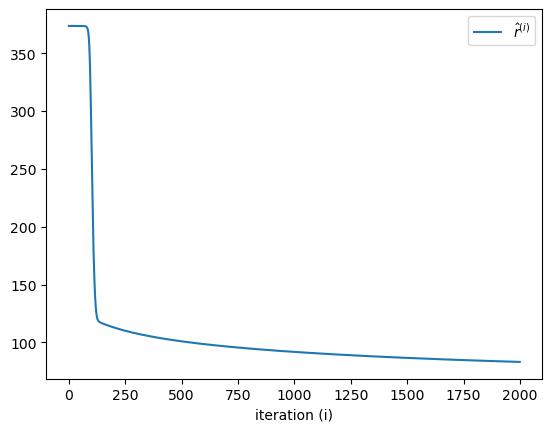

In [27]:
plt.plot(shs_eps, label=r"$\hat{r}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

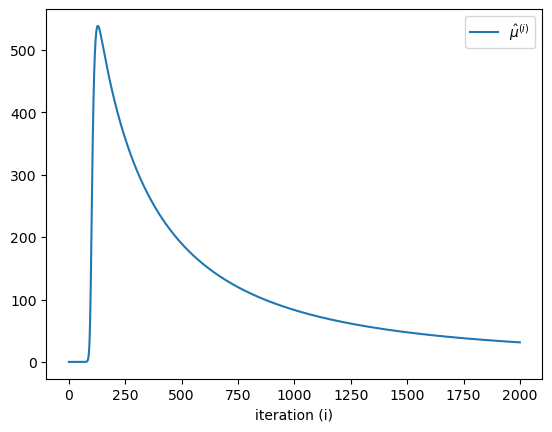

In [28]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

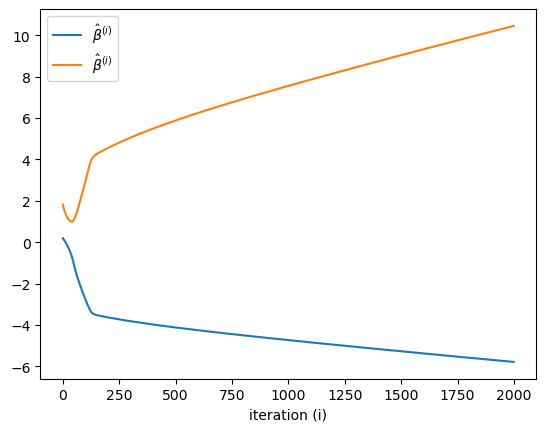

In [29]:
plt.plot(bhs, label=r"$\hat{\beta}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. Wald's Confidence Region

In [30]:
Rmle = np.zeros(T+T0)
d1Rm = np.zeros([d, T+T0])
d2Rm = np.zeros([d, d, T+T0])

In [31]:
for t in np.arange(T+T0):
    o = np.exp(- bmle @ A[t])
    p = 1 / (1 + o)
    q = o / (1 + o)

    Rmle[t] = K * p
    d1Rm[:,t] = K * p * q * A[t]
    d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

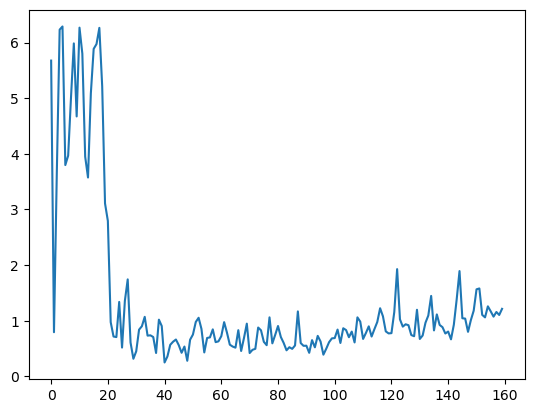

In [32]:
plt.plot(Rmle)

In [33]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
G = Rmle[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [34]:
d1G = d1Rm[:,:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
d2G = d2Rm[...,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [35]:
inv_ImG = la.inv(np.eye(T+T0)-G)

In [36]:
Pi_inv_ImG = Pi @ inv_ImG

In [37]:
EY = mmle_0 * Pi_inv_ImG[:,0]

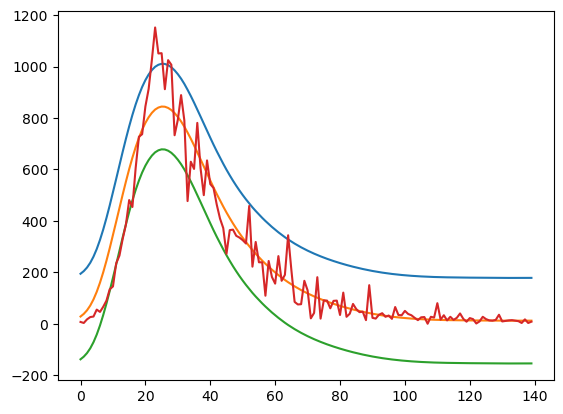

In [42]:
plt.plot(EY+2*smle_eps)
plt.plot(EY)
plt.plot(EY-2*smle_eps)
plt.plot(Y_data)

In [136]:
d1EY = mmle_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]

In [137]:
d2EY = mmle_0 * (Pi_inv_ImG @ (
    d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
    + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
    + d2G @ inv_ImG[:,:1]))[...,0]

In [138]:
Ed2l_ds2 = - 2 * T / smle_eps**2
Ed2l_dsdm = 0
Ed2l_dsdb = np.zeros(d)
Ed2l_dm2 = - np.sum(Pi_inv_ImG[:,0]**2) / smle_eps**2
Ed2l_dmdb = - np.sum(Pi_inv_ImG[:,0] * d1EY, 1) / smle_eps**2
Ed2l_db2 = - d1EY @ d1EY.T / smle_eps**2

In [139]:
Ed2l_dms2 = np.array(
    [[Ed2l_dm2, Ed2l_dsdm],
     [Ed2l_dsdm, Ed2l_ds2]]
)
Ed2l_dmsdb = np.stack([Ed2l_dmdb, Ed2l_dsdb])

In [140]:
Ihat_dth = - np.block(
    [[Ed2l_dms2, Ed2l_dmsdb],
     [Ed2l_dmsdb.T, Ed2l_db2]])

In [141]:
Ihat_dth

array([[ 3.62193499e+01, -0.00000000e+00,  4.92890325e+02,
         2.06478054e+02],
       [-0.00000000e+00,  4.82200895e-02, -0.00000000e+00,
        -0.00000000e+00],
       [ 4.92890325e+02, -0.00000000e+00,  8.40832122e+03,
         3.43859877e+03],
       [ 2.06478054e+02, -0.00000000e+00,  3.43859877e+03,
         1.40970866e+03]])

In [142]:
la.inv(Ihat_dth)[2:,2:]

array([[ 0.69368316, -1.87490453],
       [-1.87490453,  5.0718385 ]])

In [143]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

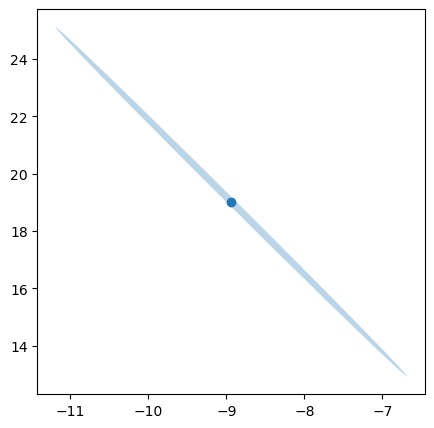

In [144]:
plt.figure(figsize=(5,5))
p = plt.scatter(*bmle)
confidence_ellipse(bmle, np.linalg.pinv(Ihat_dth)[2:,2:], 
                   plt.gca(), n_std=2.7, facecolor=p.get_facecolor(), alpha=0.3)

In [145]:
def EY_t(beta, mu_0, A):
    assert A.shape[0] > T0
    
    T = A.shape[0]-T0
    R = np.zeros(T+T0)
    for t in np.arange(T+T0):
        o = np.exp(- beta @ A[t])
        p = 1 / (1 + o)
        R[t] = K * p 
        
    # g
    g = np.zeros(T+T0)
    g[:np.minimum(T+T0,len(GPi['g']))] \
    = GPi['g'][:np.minimum(T+T0,len(GPi['g']))]
    
    # pi
    pi = np.zeros(T+T0)
    pi[:np.minimum(T+T0,len(GPi['pi']))] \
    = GPi['pi'][:np.minimum(T+T0,len(GPi['pi']))]
        
    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = R[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    
    return mu_0 * np.linalg.inv(np.eye(T+T0)-G)[:,0] @ Pi.T

In [146]:
num_sim = 20
chi_sim = np.linspace(-2.4, 2.4, num_sim)

In [147]:
u, v = np.linalg.eig(np.linalg.pinv(Ihat_dth)[2:,2:])

In [148]:
u

array([5.17254372e-04, 5.76500441e+00])

In [149]:
beta_sim = bmle + v[:,1] * np.sqrt(u[1]) * chi_sim[:,None]
EY_sim = np.zeros([num_sim, T])

In [150]:
for i, b in enumerate(beta_sim):
    EY_sim[i] = EY_t(b, mmle_0, A)

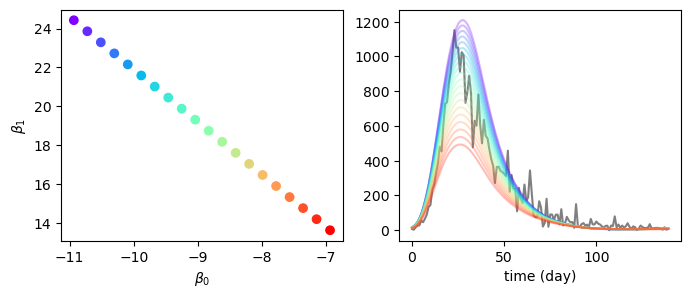

In [151]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(beta_sim[:,0],beta_sim[:,1], c=chi_sim, cmap='rainbow')
plt.xlabel(r'$\beta_0$'); plt.ylabel(r'$\beta_1$')

plt.subplot(1,2,2); 
plt.plot(Y_data, color='grey')
lines = plt.plot(EY_sim.T, alpha=0.3)
plt.xlabel('time (day)'); # plt.ylabel('expected deaths')
for i, l in enumerate(lines):
    l.set_color(plt.cm.rainbow(i/num_sim))
plt.show()

In [152]:
u, v = np.linalg.eig(np.linalg.pinv(Ihat_dth)[np.ix_([0,2,3],[0,2,3])])

In [153]:
u

array([8.07919141e+00, 1.00316830e-01, 1.01583101e-04])

In [154]:
v[:,0]

array([ 0.53853909,  0.29170959, -0.79049425])

In [155]:
beta_sim = bmle + v[1:,0] * np.sqrt(u[0]) * chi_sim[:,None]
m0_sim = mmle_0 + v[0,0] * np.sqrt(u[0]) * chi_sim[:,None]
EY_sim = np.zeros([num_sim, T])

In [156]:
for i, (m0, b) in enumerate(zip(m0_sim,beta_sim)):
    EY_sim[i] = EY_t(b, m0, A)

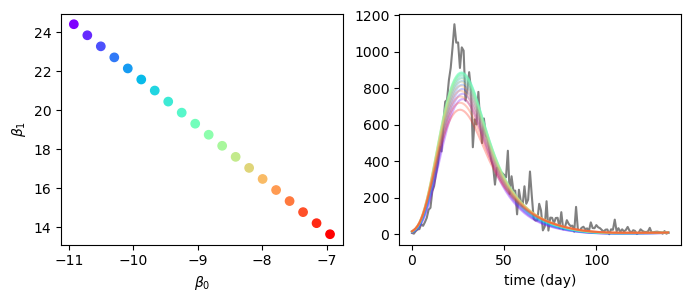

In [157]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(beta_sim[:,0],beta_sim[:,1], c=chi_sim, cmap='rainbow')
plt.xlabel(r'$\beta_0$'); plt.ylabel(r'$\beta_1$')

plt.subplot(1,2,2); 
plt.plot(Y_data, color='grey')
lines = plt.plot(EY_sim.T, alpha=0.3)
plt.xlabel('time (day)'); # plt.ylabel('expected deaths')
for i, l in enumerate(lines):
    l.set_color(plt.cm.rainbow(i/num_sim))
plt.show()

# 5. Sandwich estimator

In [158]:
L_HAC = np.floor(4* (T/100)**(2/9))

In [159]:
w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)

In [160]:
dlt_dm = Pi_inv_ImG[:,0] * (Y_data - EY) / smle_eps**2
dlt_dsp = - 1 / smle_eps + (Y_data - EY)**2 / smle_eps**3
dlt_db = d1EY * (Y_data - EY) / smle_eps**2

In [161]:
dlt_dth = np.concatenate([np.array([dlt_dm, dlt_dsp]), dlt_db], 0)

In [164]:
VEdl = dlt_dth @ w_HAC @ dlt_dth.T

In [165]:
VEdl

array([[2.79119703e+02, 2.45768363e+00, 3.16693702e+03, 1.36022665e+03],
       [2.45768363e+00, 2.44091471e-01, 1.35726194e+01, 6.60216087e+00],
       [3.16693702e+03, 1.35726194e+01, 4.09145138e+04, 1.73017873e+04],
       [1.36022665e+03, 6.60216087e+00, 1.73017873e+04, 7.33013291e+03]])

In [166]:
Ihat_sdw = Ihat_dth @ la.inv(VEdl) @ Ihat_dth

In [167]:
Ihat_sdw

array([[ 7.00489960e+00, -2.44343914e-02,  1.31831026e+02,
         5.31905898e+01],
       [-2.44343914e-02,  1.28281391e-02,  9.40732288e-01,
         3.31961714e-01],
       [ 1.31831026e+02,  9.40732288e-01,  3.12963418e+03,
         1.23925537e+03],
       [ 5.31905898e+01,  3.31961714e-01,  1.23925537e+03,
         4.91436759e+02]])

In [168]:
Ihat_dth

array([[ 3.62193499e+01, -0.00000000e+00,  4.92890325e+02,
         2.06478054e+02],
       [-0.00000000e+00,  4.82200895e-02, -0.00000000e+00,
        -0.00000000e+00],
       [ 4.92890325e+02, -0.00000000e+00,  8.40832122e+03,
         3.43859877e+03],
       [ 2.06478054e+02, -0.00000000e+00,  3.43859877e+03,
         1.40970866e+03]])

In [169]:
la.inv(Ihat_sdw)[2:,2:]

array([[ 2.76445782, -7.53540289],
       [-7.53540289, 20.5551521 ]])

In [170]:
num_sim = 20
chi_sim = np.linspace(-2.4, 2.4, num_sim)

In [171]:
u, v = np.linalg.eig(np.linalg.pinv(Ihat_sdw)[2:,2:])

In [172]:
u

array([1.78208401e-03, 2.33178278e+01])

In [173]:
beta_sim = bmle + v[:,1] * np.sqrt(u[1]) * chi_sim[:,None]
EY_sim = np.zeros([num_sim, T])

In [174]:
for i, b in enumerate(beta_sim):
    EY_sim[i] = EY_t(b, mmle_0, A)

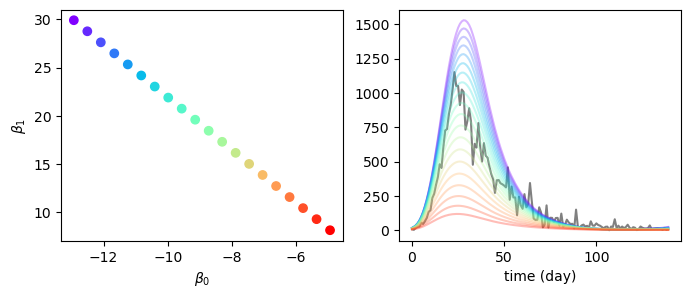

In [175]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(beta_sim[:,0],beta_sim[:,1], c=chi_sim, cmap='rainbow')
plt.xlabel(r'$\beta_0$'); plt.ylabel(r'$\beta_1$')

plt.subplot(1,2,2); 
plt.plot(Y_data, color='grey')
lines = plt.plot(EY_sim.T, alpha=0.3)
plt.xlabel('time (day)'); # plt.ylabel('expected deaths')
for i, l in enumerate(lines):
    l.set_color(plt.cm.rainbow(i/num_sim))
plt.show()

In [176]:
num_sim = 20
chi_sim = np.linspace(-2, 2, num_sim)

In [177]:
u, v = np.linalg.eig(np.linalg.pinv(Ihat_dth)[np.ix_([0,2,3],[0,2,3])])

In [178]:
u

array([8.07919141e+00, 1.00316830e-01, 1.01583101e-04])

In [179]:
beta_sim = bmle + v[1:,0] * np.sqrt(u[0]) * chi_sim[:,None]
m0_sim = mmle_0 + v[0,0] * np.sqrt(u[0]) * chi_sim[:,None]
EY_sim = np.zeros([num_sim, T])

In [180]:
for i, (m0, b) in enumerate(zip(m0_sim,beta_sim)):
    EY_sim[i] = EY_t(b, m0, A)

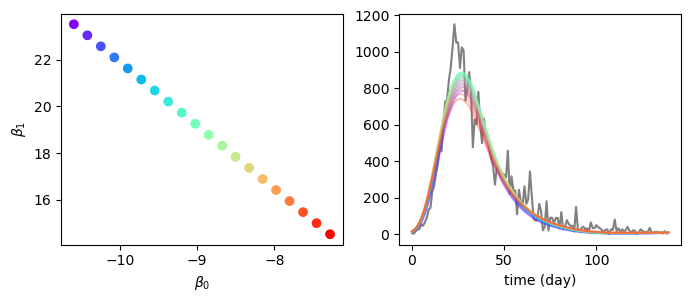

In [181]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(beta_sim[:,0],beta_sim[:,1], c=chi_sim, cmap='rainbow')
plt.xlabel(r'$\beta_0$'); plt.ylabel(r'$\beta_1$')

plt.subplot(1,2,2); 
plt.plot(Y_data, color='grey')
lines = plt.plot(EY_sim.T, alpha=0.3)
plt.xlabel('time (day)'); # plt.ylabel('expected deaths')
for i, l in enumerate(lines):
    l.set_color(plt.cm.rainbow(i/num_sim))
plt.show()

# 6. Causal forecasting

In [82]:
Tf = 50
Af = np.zeros([Tf, d])

In [169]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.5)

In [170]:
Te = T+Tf
Ae = np.concatenate([A, Af], 0)

In [171]:
# g
ge = np.zeros(Te+T0)
ge[:GPi['g'].shape[0]] = GPi['g']

# pi
pie = np.zeros(Te+T0)
pie[:GPi['pi'].shape[0]] = GPi['pi']

In [172]:
num_sim = 1000

In [173]:
bsim = np.random.multivariate_normal(bmle, la.inv(Ihat_dth)[2:,2:], num_sim)

In [174]:
Rmle = np.zeros(Te+T0)
Rsim = np.zeros([num_sim,Te+T0])

In [175]:
for t in np.arange(Te+T0):
    o = np.exp(- bmle @ Ae[t])
    p = 1 / (1 + o)
    Rmle[t] = K * p
    
    o = np.exp(- bsim @ Ae[t])
    p = 1 / (1 + o)
    Rsim[:,t] = K * p

In [176]:
Pie = alpha * np.concatenate([[0],pie])[np.maximum(0, T0 + np.arange(Te)[:,None] - np.arange(Te+T0))]
Ge = Rmle[:,None] * np.concatenate([[0],ge])[np.maximum(0, np.arange(Te+T0)[:,None] - np.arange(Te+T0))]
Gesim = Rsim[:,:,None] * np.concatenate([[0],ge])[np.maximum(0, np.arange(Te+T0)[:,None] - np.arange(Te+T0))]

In [177]:
EYf = mmle_0 * np.linalg.inv(np.eye(Te+T0)-Ge)[:,0] @ Pie.T
EYf_sim = mmle_0 * np.linalg.inv(np.eye(Te+T0)-Gesim)[:,:,0] @ Pie.T

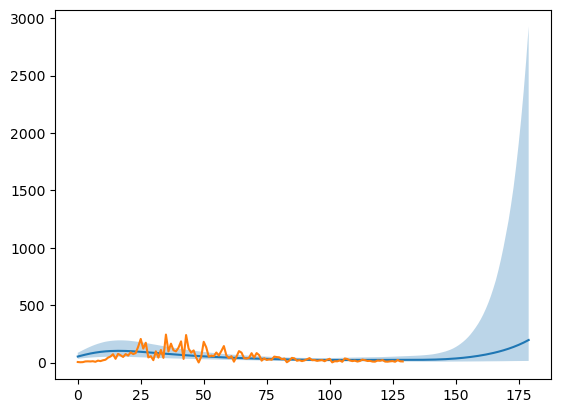

In [180]:
plt.plot(EYf)
plt.fill_between(np.arange(Te), np.quantile(EYf_sim, 0.975, 0), np.quantile(EYf_sim, 0.025, 0),
                 alpha=0.3)
plt.plot(Y_data)

In [ ]:
EY_sim